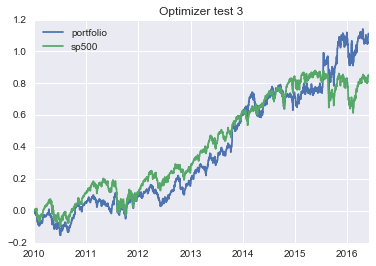

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


# get input datas
def get_stock_data(symbol):
    # 01-02 Join SPY data
    df = pd.read_csv('yahoo/{}.csv'.format(symbol), index_col='Date', parse_dates=True,
                     usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'],
                     na_values=['nan'])
    df.dropna()
    return df


stocks = {}
symbols = ['sp500', 'GLD', 'AAPL', 'GOOGL', 'FB']
for symbol in symbols:
    stocks[symbol] = get_stock_data(symbol)

# 01-01
# plot
# fb['High'].plot()
# plt.title('Facebook\'s High')

# googl[['Close','Adj Close']].plot()
# plt.title('Google\'s Close & Adj Close')

# 01-02 Create an empty data frame, Join SPY data
start_date = '2010-01-01'
end_date = '2016-05-31'
dates = pd.date_range(start_date, end_date)
# empty_data_frame=pd.DataFrame(index=dates)
# joined_df=empty_data_frame.join(aapl, how='left')
# joined_df=joined_df.dropna()
# print joined_df

# 01-02 Read in more stocks
close_df = pd.DataFrame(index=dates)
for stock_name in stocks:
    stock = stocks[stock_name]
    temp_df = stock[['Close']].rename(columns={'Close': stock_name})
    close_df = close_df.join(temp_df)

close_df.fillna(method='ffill', inplace='TRUE')
close_df.fillna(method='bfill', inplace='TRUE')
close_df.dropna()

adj_close_df = pd.DataFrame(index=dates)
for stock_name in stocks:
    stock = stocks[stock_name]
    temp_df = stock[['Adj Close']].rename(columns={'Adj Close': stock_name})
    adj_close_df = adj_close_df.join(temp_df)

adj_close_df.fillna(method='ffill', inplace='TRUE')
adj_close_df.fillna(method='bfill', inplace='TRUE')
adj_close_df.dropna()

# 01-02 More slicing
# print close_df.ix['2016-01-01':'2016-01-05', ['FB']]

# 01-02 Problems with plotting
# close_df_plot=close_df.plot(title='Close')
# close_df_plot.set_xlabel("Date")
# close_df_plot.set_ylabel("Price")

# 01-02 Normalizing
normalized_close_df = close_df / close_df.ix[0, :]
# normalized_close_df_plot=normalized_close_df.plot(title='Normalized Close')
# normalized_close_df_plot.set_xlabel("Date")
# normalized_close_df_plot.set_ylabel("Normalized Price")

# 01-04 Compute global statistics
# print close_df.max()
# print close_df.mean()
# print close_df.min()

# 01-04 Rolling Statistics, Bollinger Bands
def draw_rolling_statistics(df, symbol, window):
    rolling_mean = df[symbol].rolling(window=window).mean()
    rolling_std = df[symbol].rolling(window=window).std()
    bollinger_band_upper = rolling_mean + 2 * rolling_std
    bollinger_band_lower = rolling_mean - 2 * rolling_std
    plot = df[symbol].plot(title='{} rolling mean'.format(symbol), label='price')
    rolling_mean.plot(label='rolling mean', ax=plot)
    bollinger_band_upper.plot(label='upper band', ax=plot)
    bollinger_band_lower.plot(label='lower band', ax=plot)
    plot.set_xlabel("Date")
    plot.set_ylabel("Price")
    plot.legend(loc='upper left')
    plt.show()
# draw_rolling_statistics(close_df, 'sp500', 20)
# draw_rolling_statistics(close_df, 'FB', 20)

# 01-04 Daily returns
def calculate_daily_returns(df):
    daily_returns=df.copy()
    daily_returns=(daily_returns/daily_returns.shift(1))-1
    return daily_returns[1:]

daily_returns=calculate_daily_returns(adj_close_df)
# daily_returns.plot(title="Daily returns")

# 01-04 Cumulative returns
def calculate_cumulative_returns(df):
    return (df/df.ix[0]) - 1

cumulative_returns=calculate_cumulative_returns(adj_close_df)
# cumulative_returns_plot=cumulative_returns.plot(title="Cumulative returns")
# cumulative_returns_plot.set_xlabel("Date")
# cumulative_returns_plot.set_ylabel("Cumulative return")


# 01-05 Using fillna()
close_df.fillna(method='ffill', inplace='TRUE')
close_df.fillna(method='bfill', inplace='TRUE')
# close_df.plot()


# 01-06 Computing histogram statistics
sp500_daily_returns=daily_returns['sp500']
sp500_daily_returns_mean=sp500_daily_returns.mean()
sp500_daily_returns_std=sp500_daily_returns.std()

# sp500_daily_returns.hist(bins=20)
# plt.title('sp500 Daily Returns Histogram')
# plt.axvline(sp500_daily_returns_mean, color='w', linestyle='dashed', linewidth=2)
# plt.axvline(sp500_daily_returns_std, color='r', linestyle='dashed', linewidth=2)
# plt.axvline(-sp500_daily_returns_std, color='r', linestyle='dashed', linewidth=2)
# plt.show()
# print daily_returns.kurtosis()

# 01-06 Plot two histograms together
#daily_returns.hist(bins=20, layout=(2,3), figsize=(30,10))
# daily_returns["AAPL"].hist(bins=20, label="AAPL")
# daily_returns["sp500"].hist(bins=20, label="sp500")
# plt.legend(loc='upper left')

# 01-06 Scatterplots
def draw_scatter_plot(daily_returns, x_symbol, y_symbol):
    daily_returns.plot(kind='scatter', x=x_symbol, y=y_symbol, title='{} vs {} Daily return Scatter plot'.format(x_symbol, y_symbol))
    beta, alpha=np.polyfit(daily_returns[x_symbol], daily_returns[y_symbol], 1)
    plt.plot(daily_returns[x_symbol], beta * daily_returns[x_symbol] + alpha, '-', color='r')
    plt.show()

# draw_scatter_plot(daily_returns, 'sp500', 'GLD')
# draw_scatter_plot(daily_returns, 'sp500', 'GOOGL')
# draw_scatter_plot(daily_returns, 'sp500', 'FB')
# print daily_returns.corr(method='pearson')


# 01-07 Sharpe ratio and other portfolio statistics
def calculate_porfolio_value(df, start_val, symbols, allocs):
    portfolio_close_df=df[symbols]
    normalized_df=portfolio_close_df/portfolio_close_df.ix[0,:]
    alloced_df=normalized_df * allocs
    position_vals_df=alloced_df * start_val
    portfolio_val_df=position_vals_df.sum(axis=1)
    return portfolio_val_df

port_start_val=1000000
port_symbols=['sp500', 'GOOGL', 'FB', 'GLD']
port_allocs=[0.4,0.4,0.1,0.1]
port_val_df=calculate_porfolio_value(adj_close_df, port_start_val, port_symbols, port_allocs)
port_daily_rets=calculate_daily_returns(port_val_df)
port_cum_ret=calculate_cumulative_returns(port_val_df)
port_daily_ret_avg=port_daily_rets.mean()
port_daily_ret_std=port_daily_rets.std() # daily risk.
# What is the risk free rate?
# 1. LIBOR
# 2. 3mo T-bill
# 3. 0%
# traditional shortcut. transform from annual amount into a daily amount.
# if yearly risk free rate as 10%.
yearly_risk_free_rate=0.1 # begining of the year : 1.0 -> end of the year : 1.1
daily_risk_free_rate=(1 + yearly_risk_free_rate) ** (1/252) - 1
port_daily_sharpe_ratio=(port_daily_rets-daily_risk_free_rate).mean()/(port_daily_rets).std()

# k = sqrt(number of samples per year)
daily_k=np.sqrt(252)
weekly_k=np.sqrt(52)
monthly_k=np.sqrt(12)
port_annualized_sharpe_ratio=daily_k * port_daily_sharpe_ratio



# 01-08 Optimizers: Building a parameterized model
import scipy.optimize as spo
def f(X):
    Y=(X-1.5)**2+0.5
    print "X={},Y={}".format(X,Y)
    return Y

def test_run():
    Xguess=2.0
    min_result=spo.minimize(f, Xguess, method='SLSQP', options={'disp':True})
    print "Minima found at:X={},Y={}".format(min_result.x, min_result.fun)
    
    # Plot function values, mark minima
    Xplot=np.linspace(0.5, 2.5, 21)
    Yplot=f(Xplot)
    plt.plot(Xplot, Yplot)
    plt.plot(min_result.x, min_result.fun, 'ro')
    plt.title("Minima of an objective function")
    plt.show()

#test_run()

def error(line, data):
    err=np.sum((data[:,1]-(line[0] * data[:,0] + line[1])) ** 2)
    return err

def fit_line(data, error_func):
    l=np.float32([0,np.mean(data[:,1])])
    x_ends=np.float32([-5,10])
    plt.plot(x_ends, l[0]*x_ends + l[1], 'm--', linewidth=2.0, label="Initial guess")
    result = spo.minimize(error_func, l, args=(data,), method="SLSQP", options={'disp':True})
    return result.x

def test_run2():
    # Define original line
    l_orig=np.float32([4,2])
    print "Original line: C0={}, C1={}".format(l_orig[0], l_orig[1])
    Xorig=np.linspace(0,10,21)
    Yorig=l_orig[0] * Xorig + l_orig[1]
    plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label="Original line")
    
    # Generate noisy data points
    noise_sigma=3.0
    noise=np.random.normal(0,noise_sigma, Yorig.shape)
    data=np.asarray([Xorig, Yorig+noise]).T
    plt.plot(data[:,0], data[:,1], 'go', label="Data points")
    
    # Try to fit a line to this data
    l_fit=fit_line(data, error)
    print "Fitted line:C0={}, C1={}".format(l_fit[0], l_fit[1])
    plt.plot(data[:,0], l_fit[0] * data[:,0] + l_fit[1], 'r--', linewidth=2.0, label='Fit')
    plt.title("Optimizer test 2")
    plt.legend(loc='upper left')
    plt.show()

# test_run2()

def error_poly(C, data):
    err=np.sum((data[:,1] - np.polyval(C, data[:,0])) ** 2)
    return err

def fit_poly(data, error_func, degree=3):
    Cguess=np.poly1d(np.ones(degree+1, dtype=np.float32))
    x=np.linspace(-10,10,21)
    plt.plot(x,np.polyval(Cguess, x), 'm--', linewidth=2.0, label="Initial guess")
    result=spo.minimize(error_func, Cguess, args=(data,), method='SLSQP', options={'disp':True})
    return np.poly1d(result.x)

def test_run3():
    # Define original line
    l_orig=np.float32([3,-2,2,1])
    print "Original line: C0={}, C1={}".format(l_orig[0], l_orig[1])
    Xorig=np.linspace(-10,10,21)
    Yorig=np.polyval(l_orig, Xorig)
    plt.plot(Xorig, Yorig, 'b--', linewidth=2.0, label="Original line")
    
    # Generate noisy data points
    noise_sigma=1000.0
    noise=np.random.normal(0,noise_sigma, Yorig.shape)
    data=np.asarray([Xorig, Yorig+noise]).T
    plt.plot(data[:,0], data[:,1], 'go', label="Data points")
    
    # Try to fit a line to this data
    l_fit=fit_poly(data, error_poly, degree=3)
    plt.plot(data[:,0], np.polyval(l_fit, data[:,0]), 'r--', linewidth=2.0, label='Fit')
    plt.title("Optimizer test 3")
    plt.legend(loc='upper left')
    plt.show()

#test_run3()


# 01-09 Optimizers: How to optimize portfolio
port_cum_ret.plot(label='portfolio')
calculate_cumulative_returns(adj_close_df['sp500']).plot(label='sp500')
plt.title("Optimizer test 3")
plt.legend(loc='upper left')
plt.show()

# Framing the problem. what is f(x)?
# f(x) = -Sharpe ratio 
# x=alloc of portfolio
# ranges of x : for X 0~1
# constraints. sigma abs(x) = 1.0 (abs() need due to short/long.)